# Stock Analysis Using LSTM - MVP (MULTI-ITERATION)
- train an LSTM on a variable number of features
- vary on lookback (LSTM window) and training window (years before present date)
- multi input version
- multi day lookahead (predict x days ahead) version
- this version is designed to ingest key parameters from a CSV files and perform multiple training and rendering iterations based on the values in the CSV file
- APR 15 updates: writing a single output CSV file for a single input CSV file
- APR 24 updates: added VIX as an optional feature
- MAY 6 updates: cleaned up defect when ticker missing from sector CSV; added new features: 'personal_sav_rate', 'oil_price', 'schiller_ratio', 'consumer_sentiment'
- MAY 12 updates: added new features "public_debt" and URTH; added 'feature_list" as a column in output CSV (note that since feature_list is fixed for entries in the input CSV, this column in the output CSV has the same value in every row).
- MAY 15 fixes: updated the code that merges the input feature tables so that only the selected features are merged, so that the final feature table goes back as far as the features with the latest start point, as opposed to the latest start point of all possible features.
- MAY 16: added new features: "us_dollar_index" and added documentation of starting dates for features (next cell) 
- JUNE 22: added feature frequency to feature beginning date list
- JUNE 23: preliminarily added static load: features in static_feature_list are saved using stock_analysis_static_load.ipynb
- JUNE 28: refactored quandl features into a single loop
- TBD: load saved static CSVs in this notebook. static_load_end controls the end date of the static load
- JULY 10: replace calls to yahoo api with calls to stooq - yahoo api stopped working as of July 2021 - JULY 18: remove inadequate yahoo api replacement
- AUG 10: integrate the saved close info for tickers and MarketStack. NOTE - no other alternate source found for VIX, so that needs to be removed as a feature
- AUG 15: added features: 'non_farm','m2_money','st_louis'
- AUG 28: test Luc reported issue w. identical good days on multiple runs
- SEP 4: make the default target "adj_close" rather than "Close" and corrected path for ticker CSV files on Colab to fixed path on Luc's Drive
- SEP 4b: added "volume" as a feature. The values are taken from the individual ticker CSV files. If there is an "adj_volume" value for a data point, that is used. If not, "volume" is used.
- DEC 29: experiment bringing in sample ticker JSON fundamentals

This notebook adapted from https://www.kaggle.com/faressayah/stock-market-analysis-prediction-using-lstm

# Feature series frequency and beginning dates:
- '2 YR','30 YR' - daily; 1990-01-02
- 'Sector_Close' - daily; depends on sector
- 'VIX' - daily; 2001-05-15
- 'URTH' - daily; 2012-01-12
- 'personal_sav_rate' - monthly; 1959-01-01
- 'oil_price' - daily; 1986-01-02
- 'schiller_ratio' - monthly; 1871-02-01
- 'consumer_sentiment' - every 4 months, then monthly; 1952-11-30
- 'public_debt' - quarterly; 1966-01-01
- 'Bullish', 'Bearish' - weekly; 1987-06-26
- 'gdp' - quarterly; 1947-01-01
- 'cpi' - monthly; 1947-01-01
- 'us_dollar_index' - yearly; 1995-01-01

# Parameters to incorporate
Investor sentiment: https://www.quandl.com/data/AAII/AAII_SENTIMENT-AAII-Investor-Sentiment-Data
GDP: https://www.quandl.com/data/FRED/GDP-Gross-Domestic-Product
Consumer Price Index (as proxy for inflation): https://www.quandl.com/data/FRED/CPIAUCSL-Consumer-Price-Index-for-All-Urban-Consumers-All-Items (I think these figures are derived from the same source I put in the factor spreadsheet: https://www.bls.gov/news.release/cpi.toc.htm)
Civilian unemployment rate: https://www.quandl.com/data/FRED/UNRATE-Civilian-Unemployment-Rate

# Import required libraries and set up notebook


In [71]:
! python --version

Python 3.7.4


In [72]:
! pip install quandl
#! pip install pip --upgrade
#! pip install pandas-datareader
print("past pandas_datareader")
#! pip install yahoo_fin
import pandas as pd
import numpy as np
import os
import requests
import json
from io import StringIO
import yaml
from datetime import date
import requests
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
#import pandas_datareader as pdr
from pandas_datareader.data import DataReader
# import yahoo_fin.stock_info as si

# For time stamps
from datetime import datetime

# for LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
from keras.models import Model
# from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
# access datasets from quandl.com - need to pip install Quandl to use
import quandl
on_colab = False
verboseout = True
results_columns = ['ticker','feature_list','total deviation','avg deviation','max deviation','min deviation','proportion good days']    
config_file = 'model_training_config.yml'
feature_df_dict = {}

past pandas_datareader


You should consider upgrading via the 'c:\users\ryanm\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [73]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [74]:
'''
r = requests.get('https://finnhub.io/api/v1/stock/dividend2?symbol=AAPL&token=c16hj0f48v6ppg7erf7g')
print(r.json())
'''

"\nr = requests.get('https://finnhub.io/api/v1/stock/dividend2?symbol=AAPL&token=c16hj0f48v6ppg7erf7g')\nprint(r.json())\n"

In [75]:
start_timestamp = datetime.now()
if on_colab:
    from google.colab import drive
    drive.mount('/content/drive')

In [76]:
if on_colab:
    %cd /content/drive/MyDrive/karma_jan_2021/stock_investigation/notebooks

# Load config parameters

In [77]:
# load config file
current_path = os.getcwd()
print("current directory is: "+current_path)

path_to_yaml = os.path.join(current_path, config_file)
print("path_to_yaml "+path_to_yaml)
try:
    with open (path_to_yaml, 'r') as c_file:
        config = yaml.safe_load(c_file)
except Exception as e:
    print('Error reading the config file')

current directory is: C:\personal\karma_stocks_2021\stock_investigation\notebooks
path_to_yaml C:\personal\karma_stocks_2021\stock_investigation\notebooks\model_training_config.yml


In [78]:
# set parameters
# parameters that could change if the CSV file is used to drive multiple runs are set in the dictionary parms
parms = {}
parms['repeatable_run'] = config['general']['repeatable_run']
# fix seeds to get identical results on mulitiple runs
if parms['repeatable_run']:
    from numpy.random import seed
    seed(4)
    # dumb switch to make up for dumb regression going from TF 1 to TF 2
    if tf.__version__ == '1.15.0':
        tf.set_random_seed(7)
    else:
        tf.random.set_seed(7)


#master_date_mode', 'master_start', 'master_end',
#       'repeatable_run', 'years_window', 'training_proportion',
#       'close_threshold', 'look_back', 'look_ahead', 'look_ahead_scale',
#       'tech_list'
list_parms = ['tech_list']
plot_all = config['general']['verboseout']
use_saved_model = config['general']['presaved']
ust_cols = config['general']['ust_cols']
report_round = config['general']['report_round']
# list of ticket symbols
# e.g. tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
parms['tech_list'] = config['tech_list']
# dictionary to seed stock handles with company names
saved_model_modifier = config['files']['saved_model_modifier']
# get the column lists
parms['close_threshold'] = config['general']['close_threshold']
quandl_token = config['general']['quandl_token']
rapidai_key = config['general']['rapidai_key']
# number of days previous used to predict subsequent day
parms['look_back'] = config['general']['look_back']
# gap in day betwen the last day previous and the subsequent day being predicted
parms['look_ahead'] = config['general']['look_ahead']
parms['look_ahead_scale'] = config['general']['look_ahead_scale']
parms['years_window'] = config['general']['years_window']
# target column
lstm_target = config['general']['lstm_target']
# list from target column
lstm_target_list = [lstm_target]
# additional features beyond the target column
feature_list = config['general']['feature_list']
print('feature_list before is: ',feature_list)
# parse feature_list to deal with features in the ticker list
ticker_feature_list = config['general']['ticker_feature_list']
# remove ticker features - they need to be dealt with separately
feature_list = [item for item in feature_list if item not in ticker_feature_list]
print('feature_list after is: ',feature_list)
# complete list of features LSTM trained on

# switch to determine normalization method
min_max_norm = config['general']['min_max_norm']
eod_token = config['general']['eod_token']
eod_historical_token = config['general']['eod_historical_token']
marketstack_token = config['general']['marketstack_key']
sector_ticker = config['files']['sector_ticker']
multi_parm_file = config['files']['multi_parm_file'] # CSV file containing parms for multiple runs
debug_on = config['general']['debug_on']
max_years_back = config['general']['max_years_back']
parms['master_date_mode'] = config['general']['master_date_mode']
parms['master_start'] = config['general']['master_start']
parms['master_end'] = config['general']['master_end']
parms['training_proportion'] = config['general']['training_proportion']
static_feature_list = config['static_load']['static_feature_list']
multi_parm_run = config['general']['multi_parm_run']
conventional_feature_list = config['general']['conventional_feature_list']
conventional_feature_keys = config['conventional_feature_keys']
fundamentals_mockup_file = config['files']['json_fundamentals_mockup']
main_fundamentals_switch = config['general']['main_fundamentals_switch']
fundamentals_feature_list = config['general']['fundamentals_feature_list']
if main_fundamentals_switch:
    #include fundamentals features
    lstm_feature_list = lstm_target_list+feature_list+ticker_feature_list+fundamentals_feature_list
else:
    lstm_feature_list = lstm_target_list+feature_list+ticker_feature_list
    

current_fundamentals_directory = config['files']['current_fundamentals_directory']    
    
    
    
    

# ensure value of training_proportion is valid
if (parms['training_proportion'] < 0.25) or (parms['training_proportion'] > 0.9):
    print("setting default training proportion")
    parms['training_proportion'] = 0.8

feature_list before is:  ['2 YR', 'us_dollar_index', 'personal_sav_rate', 'oil_price', 'schiller_ratio', 'consumer_sentiment', 'public_debt', 'Bullish', 'Bearish', 'gdp', 'cpi', 'unemployment', 'non_farm', 'm2_money', 'st_louis', 'volume']
feature_list after is:  ['2 YR', 'us_dollar_index', 'personal_sav_rate', 'oil_price', 'schiller_ratio', 'consumer_sentiment', 'public_debt', 'Bullish', 'Bearish', 'gdp', 'cpi', 'unemployment', 'non_farm', 'm2_money', 'st_louis']


In [79]:
config

{'general': {'verboseout': False,
  'includetext': True,
  'on_colab': False,
  'debug_on': True,
  'presaved': False,
  'savemodel': False,
  'picklemodel': True,
  'save_model_plot': False,
  'tensorboard_callback': False,
  'hctextmax': 7000,
  'maxwords': 6000,
  'textmax': 50,
  'pickled_data_file': '20142018_0930.pkl',
  'pickled_dataframe': 'AB_NYC_2019_output_aug19_2020.pkl',
  'modifier': 'oct05_2020',
  'targetthresh': 6.0,
  'targetcontinuous': False,
  'target_col': 'price',
  'emptythresh': 6000,
  'zero_weight': 1.0,
  'one_weight': 45.878,
  'one_weight_offset': 0,
  'patience_threshold': 3,
  'main_fundamentals_switch': False,
  'min_max_norm': True,
  'master_date_mode': True,
  'master_start': '2016-05-01',
  'master_end': '2021-05-01',
  'repeatable_run': False,
  'years_window': 2,
  'max_years_back': 20,
  'training_proportion': 0.8,
  'close_threshold': 0.01,
  'report_round': 4,
  'ust_cols': ['2 YR'],
  'quandl_token': 'uCghYBw8CtpUvWct_W8c',
  'finnhumb_key': '

# Static Load functions
- functions to ingest data saved by stock_analysis_static_load.ipynb

In [80]:
# given a path return the list of files in the directory
def get_static_loads(path,prefix):
    files = os.listdir(path)
    # files_xls = [f for f in files if f[-4:] == 'xlsx']
    # startswith("hello")
    files_xls = [f for f in files if f.startswith(prefix)]
    print(files)
    print(files_xls)
    return(files_xls)

In [81]:
def get_directory_path(directory):
    '''get the fully qualified path for a peer directory of the directory where this notebook is run'''
    rawpath = os.getcwd()
    # "directory" is in a directory is a sibling to the directory containing the notebook
    if 'google.colab' in str(get_ipython()):
        # LUC: this path is now set to the fixed static_load directory in your Drive
        path = '/content/gdrive/MyDrive/Karma AI/projects/Stock Predictor/static_load/'
    else:
        path = os.path.abspath(os.path.join(rawpath, '..', directory))
    return(path)

In [82]:
def get_file_date(file_list):
    '''given a list of filename with a datetime suffix, return the filename with the most recent datetime'''
    date_list = []
    today = datetime.now()
    max_date = datetime(today.year-1, today.month, today.day)
    most_recent_file = file_list[0]
    for file_name in file_list:
        date_str = file_name[-19:-4]
        print("date_str is",date_str)
        date_time_obj = datetime.strptime(date_str,"%Y%m%d-%H%M%S")
        if date_time_obj > max_date:
            max_date = date_time_obj
            most_recent_file = file_name
    return(most_recent_file)

In [83]:
def get_current_static_loads(static_feature_list):
    most_recent_static_file_list = []
    static_file_dict = {}
    for feature in static_feature_list:
        latest_file = get_file_date(get_static_loads(get_directory_path("static_load"),feature))
        most_recent_static_file_list.append(latest_file)
        static_file_dict[feature] = latest_file
    return(most_recent_static_file_list,static_file_dict)

In [84]:
# get the most recent static load files for the list of features on static_feature_list

recent_static_files, static_file_dict = get_current_static_loads(static_feature_list)
static_file_dict


['.gitignore', 'AAL_1991-01-01_2021-08-06.csv', 'AAME_1991-01-01_2021-08-06.csv', 'AAN_1991-01-01_2021-08-06.csv', 'AAOI_1991-01-01_2021-08-06.csv', 'AAON_1991-01-01_2021-08-06.csv', 'AAPL_1991-01-01_2021-08-06.csv', 'AAP_1991-01-01_2021-08-06.csv', 'AAT_1991-01-01_2021-08-06.csv', 'AAWW_1991-01-01_2021-08-06.csv', 'AAXN_1991-01-01_2021-08-06.csv', 'AA_1991-01-01_2021-08-06.csv', 'ABBV_1991-01-01_2021-08-06.csv', 'ABCB_1991-01-01_2021-08-06.csv', 'ABC_1991-01-01_2021-08-06.csv', 'ABEO_1991-01-01_2021-08-06.csv', 'ABG_1991-01-01_2021-08-06.csv', 'ABIO_1991-01-01_2021-08-06.csv', 'ABMD_1991-01-01_2021-08-06.csv', 'ABM_1991-01-01_2021-08-06.csv', 'ABR_1991-01-01_2021-08-06.csv', 'ABTX_1991-01-01_2021-08-06.csv', 'ABT_1991-01-01_2021-08-06.csv', 'ACAD_1991-01-01_2021-08-06.csv', 'ACA_1991-01-01_2021-08-06.csv', 'ACBI_1991-01-01_2021-08-06.csv', 'ACCO_1991-01-01_2021-08-06.csv', 'ACC_1991-01-01_2021-08-06.csv', 'ACER_1991-01-01_2021-08-06.csv', 'ACGL_1991-01-01_2021-08-06.csv', 'ACHC_1991-0


['gdp20210627-204434.csv', 'gdp20210627-222520.csv', 'gdp20210825-205742.csv']
date_str is 20210627-204434
date_str is 20210627-222520
date_str is 20210825-205742
['.gitignore', 'AAL_1991-01-01_2021-08-06.csv', 'AAME_1991-01-01_2021-08-06.csv', 'AAN_1991-01-01_2021-08-06.csv', 'AAOI_1991-01-01_2021-08-06.csv', 'AAON_1991-01-01_2021-08-06.csv', 'AAPL_1991-01-01_2021-08-06.csv', 'AAP_1991-01-01_2021-08-06.csv', 'AAT_1991-01-01_2021-08-06.csv', 'AAWW_1991-01-01_2021-08-06.csv', 'AAXN_1991-01-01_2021-08-06.csv', 'AA_1991-01-01_2021-08-06.csv', 'ABBV_1991-01-01_2021-08-06.csv', 'ABCB_1991-01-01_2021-08-06.csv', 'ABC_1991-01-01_2021-08-06.csv', 'ABEO_1991-01-01_2021-08-06.csv', 'ABG_1991-01-01_2021-08-06.csv', 'ABIO_1991-01-01_2021-08-06.csv', 'ABMD_1991-01-01_2021-08-06.csv', 'ABM_1991-01-01_2021-08-06.csv', 'ABR_1991-01-01_2021-08-06.csv', 'ABTX_1991-01-01_2021-08-06.csv', 'ABT_1991-01-01_2021-08-06.csv', 'ACAD_1991-01-01_2021-08-06.csv', 'ACA_1991-01-01_2021-08-06.csv', 'ACBI_1991-01-01_

{'gdp': 'gdp20210825-205742.csv',
 'cpi': 'cpi20210825-205742.csv',
 'oil_price': 'oil_price20210825-205742.csv'}

# JSON fundamentals mockup
mockup to ingest summarized JSON fundamentals file

In [85]:
# ingest mockup JSON fundamentals file
#    json_df = pd.read_csv(json_fundamentals_path,encoding = "ISO-8859-1")
def ingest_json_fundamentals(filename, fundamentals_directory):
    json_fundamentals_path = os.path.join(get_directory_path(fundamentals_directory),filename)
    json_df = pd.read_csv(json_fundamentals_path,index_col=0)
    json_df.index = pd.to_datetime(json_df.index)
    return(json_df)

In [86]:
'''
# JSON fundamentals harness
print("JSON fundamentals harness")
json_fundamentals_df = ingest_json_fundamentals(fundamentals_mockup_file,)
# correct the type of the index
json_fundamentals_df.head()
'''

'\n# JSON fundamentals harness\nprint("JSON fundamentals harness")\njson_fundamentals_df = ingest_json_fundamentals(fundamentals_mockup_file,)\n# correct the type of the index\njson_fundamentals_df.head()\n'

# Ingest Sector Ticker file
- ingest CSV file that contains correlation between stock ticker symbols and ETF tickers as a proxy for sector tickers

In [87]:
def get_data_path():
    '''get the path for data files'''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'data'))
    return(path)

In [88]:
if 'Sector_Close' not in static_feature_list:
    sector_file = os.path.join(get_data_path(),sector_ticker)
    print("sector_file: ",sector_file)
    df_sector = pd.read_csv(sector_file,encoding = "ISO-8859-1")
    df_sector.head()

sector_file:  C:\personal\karma_stocks_2021\stock_investigation\data\sector_ticker.csv


In [89]:
df_sector.head()

,Symbol,Name,Sector,Sector Ticker,Sector ETF Ticker,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,A,Agilent Technologies Inc,Health Care,^SP500-35,IYH,NaN,- 'A',NaN,NaN,NaN,NaN
1,AAL,American Airlines Group,Industrials,^SP500-20,IYJ,NaN,- 'AAL',NaN,NaN,NaN,NaN
2,AAP,Advance Auto Parts,Consumer Discretionary,^SP500-25,XLY,NaN,- 'AAP',NaN,NaN,NaN,NaN
3,AAPL,Apple Inc.,Information Technology,^SP500-45,IYW,NaN,- 'AAPL',NaN,NaN,NaN,NaN
4,ABBV,AbbVie Inc.,Health Care,^SP500-35,IYH,NaN,- 'ABBV',NaN,NaN,NaN,NaN


# Experiment getting from EOD historical data 
- https://eodhistoricaldata.com/cp/settings
- https://eodhistoricaldata.com/api/eod/MCD.US?from=2020-01-05&to=2020-02-10&period=d&api_token=6057885c018fd9.09873427
- MCD.US consists of two parts: {SYMBOL_NAME}.{EXCHANGE_ID}, then you can use, for example, MCD.MX for Mexican Stock Exchange. or MCD.US for NYSE. Check the list of supported exchanges to get more information about stock markets we do support.
- api_token – your own API KEY, which you will get after you subscribe to our services.
- fmt – the output format. Possible values are ‘csv’ for CSV output and ‘json’ for JSON output. Default value: ‘csv’.
- period – use ‘d’ for daily, ‘w’ for weekly, ‘m’ for monthly prices. By default, daily prices will be shown.
- order – use ‘a’ for ascending dates (from old to new), ‘d’ for descending dates (from new to old). By default, dates are shown in ascending order.
- from and to – the format is ‘YYYY-MM-DD’. If you need data from Jan 5, 2017, to Feb 10, 2017, you should use from=2017-01-05 and to=2017-02-10.

In [90]:
# function to get data from EOD historical API
def get_close_data(symbol='AAPL.US', api_token='OeAFFmMliFG5orCUuwAKQ8l4WWFQ67YX', from_date = '2021-07-01', to_date = '2021-07-08'):
    session = requests.Session()
    base_url = 'https://eodhistoricaldata.com/api/eod/'+symbol
    url = 'https://eodhistoricaldata.com/api/div/%s' % symbol
    params = {'api_token': api_token,'from':from_date,'to':to_date}
    r = session.get(base_url, params=params)
    if r.status_code == requests.codes.ok:
        df = pd.read_csv(StringIO(r.text), skipfooter=0, parse_dates=[0], index_col=0, engine='python')
        return(True, df)
    else:
        print("status code",str(r.status_code))
        print("reason code",str(r.reason))
        return(False,"null")
        #raise Exception(r.status_code, r.reason, url)

In [91]:
'''
# documentation for API https://eodhistoricaldata.com/financial-apis/api-for-historical-data-and-volumes/
# https://eodhistoricaldata.com/api/eod/MCD.US?api_token=6057885c018fd9.09873427
# where 
company = 'IBM.US'
start_date, end_date = set_start_end()
result_stat, df = get_close_data(company,eod_historical_token,start_date,end_date)
'''

"\n# documentation for API https://eodhistoricaldata.com/financial-apis/api-for-historical-data-and-volumes/\n# https://eodhistoricaldata.com/api/eod/MCD.US?api_token=6057885c018fd9.09873427\n# where \ncompany = 'IBM.US'\nstart_date, end_date = set_start_end()\nresult_stat, df = get_close_data(company,eod_historical_token,start_date,end_date)\n"

# Experiment getting Sector value from stooq API
- set company to stock ticker
- set start and end to define timeframe

In [92]:

end = datetime.now()
start = datetime(end.year-20, end.month, end.day)
#start = datetime(end.year, end.month, end.day-7)
print("start is: ",str(start))
print("end is: ",str(end))
# start = datetime(end.year - parms['years_window'], end.month, end.day)
company = 'URTH'
df_test = DataReader(company,data_source='stooq', start=start, end=datetime.now())
df_test.head(10)


start is:  2002-01-22 00:00:00
end is:  2022-01-22 21:41:13.731636


,Open,High,Low,Close,Volume
Date,,,,,
2022-01-21,128.23,128.6000,126.180,126.19,347214
2022-01-20,130.29,131.5050,128.405,128.46,171590
2022-01-19,131.27,131.5600,129.590,129.67,222312
2022-01-18,131.32,131.6000,130.410,130.61,598976
2022-01-14,132.15,133.0195,131.680,133.00,276353
2022-01-13,135.06,135.1053,132.810,132.98,237942
2022-01-12,134.71,135.0200,134.080,134.61,241891
2022-01-11,132.63,134.0400,132.000,134.02,346271
2022-01-10,132.12,132.6850,130.410,132.64,467039


In [93]:
'''
vix_end = datetime.now()
vix_start = datetime(end.year, end.month-1, end.day)
print("vix_start: ",vix_start)
print("vix_end: ",vix_end)
company = 'VIX.US'
#result_stat, temp_df = get_close_data(company,eod_historical_token,vix_start,vix_end)
temp_df = DataReader(company,data_source='yahoo', start=vix_start, end=vix_end)
temp_df.head()'''

'\nvix_end = datetime.now()\nvix_start = datetime(end.year, end.month-1, end.day)\nprint("vix_start: ",vix_start)\nprint("vix_end: ",vix_end)\ncompany = \'VIX.US\'\n#result_stat, temp_df = get_close_data(company,eod_historical_token,vix_start,vix_end)\ntemp_df = DataReader(company,data_source=\'yahoo\', start=vix_start, end=vix_end)\ntemp_df.head()'

# Define start and end of analysis period

In [94]:
# DataReader: https://riptutorial.com/pandas/topic/1912/pandas-datareader
# https://pandas-datareader.readthedocs.io/en/latest/remote_data.html
# 
# Set up End and Start times for data grab
# check to see if start and end dates are hard-coded with master dates
def set_start_end():
    if parms['master_date_mode']: # start and end hardcoded by parameters
        start = parms['master_start']
        end = parms['master_end']
    else: # end is current date; start is current date minus years_window
        end = datetime.now()
        start = datetime(end.year - parms['years_window'], end.month, end.day)
    # output a test dataset
    tester = DataReader('IBM', 'stooq', start, end)
    print(tester.shape)
    return(start,end)

# Experiment with EOD API for dividend
- EOD historical data doesn't directly support Python access
- https://eodhistoricaldata.com/financial-apis/python-example/




In [95]:
import requests

import pandas as pd

from io import StringIO

# URL for dividend data
# https://eodhistoricaldata.com/api/div/AAPL.US?api_token=OeAFFmMliFG5orCUuwAKQ8l4WWFQ67YX&from=2000-01-01

def get_div_data(symbol='AAPL.US', api_token='OeAFFmMliFG5orCUuwAKQ8l4WWFQ67YX', session=None):
    if session is None:
        session = requests.Session()
    url = 'https://eodhistoricaldata.com/api/div/%s' % symbol
    params = {'api_token': api_token}
    r = session.get(url, params=params)
    if r.status_code == requests.codes.ok:
        df = pd.read_csv(StringIO(r.text), skipfooter=1, parse_dates=[0], index_col=0, engine='python')
        return(True, df)
    else:
        print("status code",str(r.status_code))
        print("reason code",str(r.reason))
        return(False,"null")
        #raise Exception(r.status_code, r.reason, url)

# Load US Treasury stats

In [96]:
# load US Treasury yield dataframe
ust_df = quandl.get("USTREASURY/YIELD", authtoken=quandl_token)

In [97]:
ust_df

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-14,0.05,0.05,0.13,0.30,0.51,0.99,1.26,1.55,1.72,1.78,2.18,2.12
2022-01-18,0.05,0.06,0.16,0.37,0.58,1.06,1.35,1.65,1.82,1.87,2.24,2.18
2022-01-19,0.05,0.06,0.17,0.36,0.57,1.04,1.33,1.62,1.78,1.83,2.20,2.14


In [98]:
#ust_df['30 YR'].mean()

In [99]:
#ust_df['2 YR'].mean()

In [100]:
#us_30 = ust_df['30 YR']

In [101]:
# new = old[['A', 'C', 'D']].copy()
ust_df_2year = ust_df[['2 YR']].copy()
ust_df_2year.head()

,2 YR
Date,
1990-01-02,7.87
1990-01-03,7.94
1990-01-04,7.92
1990-01-05,7.90
1990-01-08,7.90


In [102]:
# # # df.index.inferred_type
ust_df_2year.index.inferred_type

'datetime64'

# Load Fear and Greed Index

In [103]:
# fear and greed index Source: https://rapidapi.com/rpi4gx/api/fear-and-greed-index
import requests

url = "https://fear-and-greed-index.p.rapidapi.com/v1/fgi"

headers = {
    'x-rapidapi-key': rapidai_key,
    'x-rapidapi-host': "fear-and-greed-index.p.rapidapi.com"
    }

response = requests.request("GET", url, headers=headers)

print(response.text)

{"fgi":{"now":{"value":43,"valueText":"Fear"},"previousClose":{"value":55,"valueText":"Neutral"},"oneWeekAgo":{"value":58,"valueText":"Greed"},"oneMonthAgo":{"value":35,"valueText":"Fear"},"oneYearAgo":{"value":63,"valueText":"Greed"}},"lastUpdate":{"epochUnixSeconds":1642804200,"humanDate":"2022-01-21T22:30:00Z"}}


# Load conventional features
- these are the features with a standard format from quandl API (2 col df with second col title "Value")
- listed in config parm conventional_feature_list with quandl keys in conventional_feature_keys

In [104]:
# load the conventional features
static_path = get_directory_path("static_load")
for feature in conventional_feature_list:
    if feature in static_feature_list:
        # if they are on the static_load_list, load them from there
        feature_df_dict[feature] = pd.read_csv(os.path.join(static_path,static_file_dict[feature]),index_col=0)
        # df.index = pd.to_datetime(df.index)
        feature_df_dict[feature].index = pd.to_datetime(feature_df_dict[feature].index)
    else:
        # if not, call the API to load them
        feature_df_dict[feature] = quandl.get(conventional_feature_keys[feature], authtoken=quandl_token)
    # change the column heading from 'Value' to the feature name
    feature_df_dict[feature].columns.values[0] = feature

In [105]:
feature_df_dict['oil_price'].head()

,oil_price
Date,
1986-01-02,25.56
1986-01-03,26.00
1986-01-04,26.00
1986-01-05,26.00
1986-01-06,26.53


# Load investor sentiment

In [106]:
# investor sentiment
# https://www.quandl.com/data/AAII/AAII_SENTIMENT-AAII-Investor-Sentiment-Data
# weekly
inv_sent_df = quandl.get("AAII/AAII_SENTIMENT", authtoken=quandl_token)
inv_sent_df.head()

,Bullish,Neutral,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
Date,,,,,,,,,,,,
1987-06-26,NaN,NaN,NaN,NaN,NaN,NaN,0.380245,0.480891,0.279599,NaN,NaN,NaN
1987-07-17,NaN,NaN,NaN,NaN,NaN,NaN,0.380245,0.480891,0.279599,314.59,307.63,314.59
1987-07-24,0.36,0.50,0.14,1.0,NaN,0.22,0.380245,0.480891,0.279599,311.39,307.81,309.27
1987-07-31,0.26,0.48,0.26,1.0,NaN,0.00,0.380245,0.480891,0.279599,318.66,310.65,318.66
1987-08-07,0.56,0.15,0.29,1.0,NaN,0.27,0.380245,0.480891,0.279599,323.00,316.23,323.00


In [107]:
inv_sent_df.tail()

,Bullish,Neutral,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
Date,,,,,,,,,,,,
2021-03-25,0.509494,0.284810,0.205696,1.0,0.450599,0.303798,0.380245,0.480891,0.279599,3887.14,3864.63,3881.20
2021-04-01,0.458333,0.309524,0.232143,1.0,0.451054,0.226190,0.380245,0.480891,0.279599,4013.04,4013.04,4013.04
2021-04-08,0.569079,0.226974,0.203947,1.0,0.457611,0.365132,0.380245,0.480891,0.279599,4093.87,4089.89,4091.04
2021-04-15,0.538206,0.215947,0.245847,1.0,0.460250,0.292359,0.380245,0.480891,0.279599,4151.69,4120.87,4124.66
2021-04-22,0.526814,0.268139,0.205047,1.0,0.462819,0.321767,0.380245,0.480891,0.279599,4170.46,4160.11,4162.43


In [108]:
inv_sent_df.shape

(1762, 12)

In [109]:
# inv_sent_df2 = inv_sent_df[['Bullish','Bearish']].copy()
bullish_df = inv_sent_df[['Bullish']].copy()
bearish_df = inv_sent_df[['Bearish']].copy()
feature_df_dict['Bullish'] = bullish_df
feature_df_dict['Bearish'] = bearish_df

# Load VIX
- special ticker to get options as proxies of where investors think the market is heading 
- source: Yahoo
- frequency: daily

In [110]:
'''
# brute force to just get the VIX series for the last 20 years
vix_end = datetime.now()
vix_start = datetime(end.year-max_years_back, end.month, end.day)
print("vix_start: ",vix_start)
print("vix_end: ",vix_end)
company = '^VIX'
temp_df = DataReader(company,data_source='stooq', start=vix_start, end=vix_end)
vix_df = temp_df[["Close"]].copy()
vix_df.rename(columns={'Close':'VIX'}, inplace=True)
feature_df_dict['VIX'] = vix_df
vix_df.head()
'''

'\n# brute force to just get the VIX series for the last 20 years\nvix_end = datetime.now()\nvix_start = datetime(end.year-max_years_back, end.month, end.day)\nprint("vix_start: ",vix_start)\nprint("vix_end: ",vix_end)\ncompany = \'^VIX\'\ntemp_df = DataReader(company,data_source=\'stooq\', start=vix_start, end=vix_end)\nvix_df = temp_df[["Close"]].copy()\nvix_df.rename(columns={\'Close\':\'VIX\'}, inplace=True)\nfeature_df_dict[\'VIX\'] = vix_df\nvix_df.head()\n'

# Join input dataframes

In [111]:
add_date = np.datetime64(date.today())
add_date
ass_feat = []
print("udf shape before: ",ust_df.shape)
for feature_df in feature_df_dict:
    print("filling in df for:",feature_df)
    # set the value of the end row
    feature_df_dict[feature_df].loc[add_date] = [feature_df_dict[feature_df][feature_df].iloc[-1]]
    # fill in the daily values
    feature_df_dict[feature_df] = feature_df_dict[feature_df].resample('D').ffill()
    print("shape of df: ",feature_df_dict[feature_df].shape)
    # join to main df
    if feature_df in feature_list:
        ust_df = pd.merge(ust_df,feature_df_dict[feature_df],on=['Date'],how='inner')
        ass_feat.append(feature_df)
#usf_df_mockup = pd.merge(ust_df,json_fundamentals_df,on=['Date'],how='inner')
print("udf shape after: ",ust_df.shape)
print("feature list is:",ass_feat)
ust_df.head()


    

udf shape before:  (8022, 12)
filling in df for: us_dollar_index
shape of df:  (9884, 1)
filling in df for: public_debt
shape of df:  (20476, 1)
filling in df for: personal_sav_rate
shape of df:  (23033, 1)
filling in df for: oil_price
shape of df:  (13170, 1)
filling in df for: schiller_ratio
shape of df:  (55143, 1)
filling in df for: consumer_sentiment
shape of df:  (25256, 1)
filling in df for: gdp
shape of df:  (27416, 1)
filling in df for: cpi
shape of df:  (27416, 1)
filling in df for: unemployment
shape of df:  (27051, 1)
filling in df for: non_farm
shape of df:  (30338, 1)
filling in df for: m2_money
shape of df:  (23033, 1)
filling in df for: st_louis
shape of df:  (10250, 1)
filling in df for: Bullish
shape of df:  (12630, 1)
filling in df for: Bearish
shape of df:  (12630, 1)
udf shape after:  (6772, 26)
feature list is: ['us_dollar_index', 'public_debt', 'personal_sav_rate', 'oil_price', 'schiller_ratio', 'consumer_sentiment', 'gdp', 'cpi', 'unemployment', 'non_farm', 'm2_

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,schiller_ratio,consumer_sentiment,gdp,cpi,unemployment,non_farm,m2_money,st_louis,Bullish,Bearish
Date,,,,,,,,,,,,,,,,,,,,,
1995-01-03,NaN,NaN,5.95,6.66,7.23,7.73,7.84,7.88,7.91,7.88,...,20.22,95.1,7522.289,150.5,5.6,116501.0,2.155,1.034,0.40,0.17
1995-01-04,NaN,NaN,5.85,6.57,7.15,7.62,7.75,7.81,7.82,7.82,...,20.22,95.1,7522.289,150.5,5.6,116501.0,2.155,1.034,0.40,0.17
1995-01-05,NaN,NaN,5.88,6.61,7.32,7.66,7.83,7.87,7.89,7.88,...,20.22,95.1,7522.289,150.5,5.6,116501.0,2.155,1.034,0.44,0.25
1995-01-06,NaN,NaN,5.90,6.61,7.26,7.64,7.81,7.87,7.89,7.87,...,20.22,95.1,7522.289,150.5,5.6,116501.0,2.155,1.121,0.44,0.25
1995-01-09,NaN,NaN,6.00,6.67,7.27,7.68,7.84,7.90,7.92,7.89,...,20.22,95.1,7522.289,150.5,5.6,116501.0,2.155,1.121,0.44,0.25


In [112]:
#['2 YR','30 YR', 'Sector_Close','VIX','URTH', 'personal_sav_rate', 'oil_price', 'schiller_ratio', 'consumer_sentiment','public_debt', 'Bullish', 'Bearish', 'gdp', 'cpi', 'unemployment']

In [113]:
ust_df.head()

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,schiller_ratio,consumer_sentiment,gdp,cpi,unemployment,non_farm,m2_money,st_louis,Bullish,Bearish
Date,,,,,,,,,,,,,,,,,,,,,
1995-01-03,NaN,NaN,5.95,6.66,7.23,7.73,7.84,7.88,7.91,7.88,...,20.22,95.1,7522.289,150.5,5.6,116501.0,2.155,1.034,0.40,0.17
1995-01-04,NaN,NaN,5.85,6.57,7.15,7.62,7.75,7.81,7.82,7.82,...,20.22,95.1,7522.289,150.5,5.6,116501.0,2.155,1.034,0.40,0.17
1995-01-05,NaN,NaN,5.88,6.61,7.32,7.66,7.83,7.87,7.89,7.88,...,20.22,95.1,7522.289,150.5,5.6,116501.0,2.155,1.034,0.44,0.25
1995-01-06,NaN,NaN,5.90,6.61,7.26,7.64,7.81,7.87,7.89,7.87,...,20.22,95.1,7522.289,150.5,5.6,116501.0,2.155,1.121,0.44,0.25
1995-01-09,NaN,NaN,6.00,6.67,7.27,7.68,7.84,7.90,7.92,7.89,...,20.22,95.1,7522.289,150.5,5.6,116501.0,2.155,1.121,0.44,0.25


In [114]:
ust_df.tail()

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,schiller_ratio,consumer_sentiment,gdp,cpi,unemployment,non_farm,m2_money,st_louis,Bullish,Bearish
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-14,0.05,0.05,0.13,0.30,0.51,0.99,1.26,1.55,1.72,1.78,...,39.98,70.6,22722.581,272.265,3.9,148951.0,1.115,-0.07,0.526814,0.205047
2022-01-18,0.05,0.06,0.16,0.37,0.58,1.06,1.35,1.65,1.82,1.87,...,39.98,70.6,22722.581,272.265,3.9,148951.0,1.115,-0.07,0.526814,0.205047
2022-01-19,0.05,0.06,0.17,0.36,0.57,1.04,1.33,1.62,1.78,1.83,...,39.98,70.6,22722.581,272.265,3.9,148951.0,1.115,-0.07,0.526814,0.205047
2022-01-20,0.05,0.09,0.17,0.36,0.60,1.08,1.34,1.62,1.77,1.83,...,39.98,70.6,22722.581,272.265,3.9,148951.0,1.115,-0.07,0.526814,0.205047
2022-01-21,0.05,0.08,0.17,0.35,0.58,1.01,1.28,1.54,1.70,1.75,...,39.98,70.6,22722.581,272.265,3.9,148951.0,1.115,-0.07,0.526814,0.205047


# Stitch batch load and current ticker values

In [115]:
# get raw data from marketstack
def get_close_data_marketstack(symbol='AAPL.US', api_token=marketstack_token, from_date = '2021-07-01', to_date = '2021-07-08'):
    session = requests.Session()
    print("symbol is ",symbol)
    print("from_date ",from_date)
    print("to_date ", to_date)
    # base_url = 'http://api.marketstack.com/v1/tickers/'+symbol+'/eod'
    base_url = 'http://api.marketstack.com/v1/eod'
    params = {'access_key': marketstack_token,'symbols':symbol,'limit':10000,'date_from':from_date,'date_to':to_date}
    r = session.get(base_url, params=params)
    
    ticker_dict = json.loads(r.text)["data"]
    # print("ticker_dict is ", ticker_dict)
    if r.status_code == requests.codes.ok:
        #print("status OK ")
        df = pd.DataFrame.from_dict(ticker_dict, orient='columns')
        #df = pd.read_csv(StringIO(r.text), skipfooter=0, parse_dates=[0], index_col=0, engine='python')
        return(True, df)
    else:
        print("status code",str(r.status_code))
        print("reason code",str(r.reason))
        return(False,"null")
        #raise Exception(r.status_code, r.reason, url)

In [116]:
# clean up dataframe returned by marketstack
def ms_df_cleanup(df):
    # keep just the yyyy-mm-dd portion of date column
    df['date'] = df['date'].str[0:10]
    # rename the column to be consistent
    df.rename(columns = {'date': 'Date','close': 'Close'}, inplace = True)
    # set Date to be the index
    df.set_index('Date', inplace = True)
    df.index = pd.to_datetime(df.index)
    # reverse index to match other data sources
    df = df[::-1]
    #df.iloc[::-1]
    return(df)

In [117]:
def parse_static_load(filename):
    # working backwards from the end of the filename to get the start and end dates
    end_date = filename[-14:-4]
    start_date = filename[-25:-15]
    start_date_date = datetime.strptime(start_date,"%Y-%m-%d")
    end_date_date = datetime.strptime(end_date,"%Y-%m-%d")
    return(start_date, end_date, start_date_date, end_date_date)

In [118]:
# use adj_close rather than Close across the board
def replace_ms_target(df):
    # due to the impact of stock splits, replace Close value with adj_close if it exists
    # df["COL3"] = df["COL1"].fillna(df["COL2"])
    df['Close'] = df['adj_close'].fillna(df['Close'])
    df['volume'] = df['adj_volume'].fillna(df['volume'])
    return(df)

In [119]:
def stitch_batch_current(ticker, static_load_dir, start, end):
    '''
    combine the saved batch load (from MarketStack) with current MarketStack stats
    ticker: the ticker being stitched
    start: beginning of the period
    end: end of the period
    '''
    # identify the batch load file for this ticker, if one exists
    print("STITCH BATCH 1 start is ",start)
    print("end is ", end)
    print("ticker is ", ticker)
    file_prefix = ticker+"_"
    files = [filename for filename in os.listdir(static_load_dir) if filename.startswith(file_prefix)]
    print("files is ", files)
    file_start, file_end, file_start_date, file_end_date = parse_static_load(files[0])
    print("file_start is ",file_start)
    print("file_end is ", file_end)
    print("file_start_date is ",file_start_date)
    print("file_end_date is ", file_end_date)
    print("ticker is ", ticker)
    print("STITCH BATCH END start is ", start)
    if str(start) > file_end:
        print(" start > file_end")
        # the specified period does not overlap with the batch load file - just call ms directly
        print("call get_close_data_marketstack with start ",start)
        print("with end ", end)
        result, raw_df = get_close_data_marketstack(ticker,marketstack_token,start, end)
        #print("raw_df is ",raw_df)
        df = ms_df_cleanup(raw_df)
    else:
        print(" start <= file_end")
        # need to get some of the data from the batch load CSV file, so read CSV file into df
        batch_df = pd.read_csv(os.path.join(static_load_dir,files[0]),index_col=0)
        print("batch_df.shape before ",batch_df.shape)
        # trim to just the batch load rows that are within the date margin
        #log_r.index = pd.to_datetime(log_r.index)
        # correct the type of the index
        batch_df.index = pd.to_datetime(batch_df.index)
        # trim just to the required timeframe
        batch_df = batch_df.loc[file_end:start]
        # reverse order of rows to match the other series
        batch_df = batch_df[::-1]
        print("batch_df.shape after ",batch_df.shape)
        # check to see if end date is past what is covered by batch load CSV
        if str(end) > file_end:
            print(" end > file_end")
            # set start date for JIT to one day after end of batch load
            jit_start = datetime(file_end_date.year, file_end_date.month, file_end_date.day+1)
            #print("jit_start is ",jit_start)
            result, raw_jit_df = get_close_data_marketstack(ticker,marketstack_token,jit_start, end)
            jit_df = ms_df_cleanup(raw_jit_df)
            print("jit_df pre concat is ",jit_df)
            print("batch_df.shape ",batch_df.shape )
            print("jit_df.shape ",jit_df.shape )
            df = pd.concat([batch_df,jit_df])
            #df = batch_df.append(jit_df)
        else:
            print(" end < file_end")
            df = batch_df
        # slice just to get the part of the df that is before start
    # check to see if start is before end date for batch load file
    # if so, load the batch load file for this ticker into a df. Filter this df to just the required dates
    # if end is after the end date for the batch load file, call MarketStack to get current data
    # transform current data from MarketStack to consistent format and combine dfs
    #
    # switch adj_close for Close if the values exist
    df = replace_ms_target(df)
    # trim to start and end dates
    # df= df[df.index < 13492] 
    df = df[df.index >= start]
    df = df[df.index <= end]
    return(df)

In [120]:
# harness to test stitch batch load
'''
start, end = set_start_end()
static_load_dir = get_directory_path("static_load")
df = stitch_batch_current("AAPL",static_load_dir,start,end)
df.head()

'''

'\nstart, end = set_start_end()\nstatic_load_dir = get_directory_path("static_load")\ndf = stitch_batch_current("AAPL",static_load_dir,start,end)\ndf.head()\n\n'

In [121]:
# create dataframe for ticker fundamentals
# ingest_json_fundamentals
def get_ticker_fundamentals_df(ticker,fundamentals_dir):
    # get the file name
    file_prefix = ticker+"_"
    if 'google.colab' in str(get_ipython()):
        # LUC: this path is now set to the directory containing test fundamentals in your Drive
        full_fundamentals_path = '/content/gdrive/MyDrive/Karma AI/projects/Stock Predictor/test_fundamentals_csvs/'
    else:
        full_fundamentals_path = get_directory_path(fundamentals_dir)
    files = [filename for filename in os.listdir(full_fundamentals_path) if filename.startswith(file_prefix)]
    filename = files[0]
    df = ingest_json_fundamentals(filename, fundamentals_dir)
    return(df)

# Main model definition
- build dataframe containing all features
- define helper functions
- run main blocks to define and train model
- run block to visualize predictions

# Block to define main dataframe
- combine closing data dataframe with additional time series data (e.g. from quandl)

In [122]:
#Get the stock quote
# tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
def define_main_df(start, end,tech_list):
    df_predict = {}
    # list of bad tickers
    exception_list = []
    if 'google.colab' in str(get_ipython()):
        # LUC: this path is now set to the fixed static_load directory in your Drive
        static_load_dir = '/content/gdrive/MyDrive/Karma AI/projects/Stock Predictor/static_load/'
    else:
        static_load_dir = get_directory_path("static_load")
    for company in tech_list:
        print("building df for company: ", company)
        try:
            #df_predict[company] = DataReader(company,data_source='yahoo', start=start, end=end)
            df_predict_temp = stitch_batch_current(company,static_load_dir,start,end)
            print("df_predict_temp.tail()")
            rows = df_predict_temp.iloc[-2:]
            print(rows)
            #df_predict_temp.tail()
            if main_fundamentals_switch:
                print("EYECATCHER: fundamentals features used")
                df_fundamentals = get_ticker_fundamentals_df(company,current_fundamentals_directory)
                df_predict[company] = pd.merge(df_predict_temp,df_fundamentals,on=['Date'],how='inner')
            else:
                df_predict[company] = df_predict_temp
            print("feature_list is ",feature_list)
            temp_feature_list = feature_list.copy()
            if 'Sector_Close' in feature_list:
                # get the sector ETF ticker corresponding with the company ticker
                sector = df_sector.loc[df_sector['Symbol'] == company,'Sector ETF Ticker'].iloc[0]
                # call Yahoo API for the sector ETF ticker
                sector_df = DataReader(sector,data_source='yahoo', start=start, end=end)
                # rename to get Sector_Close
                sector_df.rename(columns = {'Close':'Sector_Close'}, inplace=True)
                temp_feature_list.remove('Sector_Close')
            df_predict[company]['Return'] = df_predict[company]['Close']/df_predict[company]['Close'].shift() -1
            df_predict[company]['Return'] = df_predict[company]['Return'].fillna(0.0)
            # check if anything being joined
            if len(feature_list) > 0:
                print("temp_feature_list is ",temp_feature_list)
                df_predict[company] = pd.merge(df_predict[company],ust_df[temp_feature_list],on=['Date'],how='inner')
                if 'Sector_Close' in feature_list:
                    df_predict[company] = pd.merge(df_predict[company],sector_df['Sector_Close'],on=['Date'],how='inner')
        except Exception as e:
            if debug_on:
                raise
            print("exception generated "+str(e)+" attempting ticker "+company)
            # add to list of bad tickers
            exception_list.append(company)
        else:
            print("exception not generated")
    # remove bad tickers
    tech_list = [i for i in tech_list if i not in exception_list]
    print("revised tech_list is: ",tech_list)
    # df_predict[tech_list[0]].head()
    return(df_predict,tech_list)

# Define helper functions
- define helper functions used by main model training block

In [123]:
def get_model_path():
    '''get the path for data files'''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'models'))
    return(path)

In [124]:
def save_model(model,company):
    '''save the model to a file in directory models that is a peer of the directory containing this notebook'''
    model_path = get_model_path()
    modifier = datetime.now().strftime("%B%d%Y")
    save_model_path = os.path.join(model_path,company+modifier+'.h5')
    model.save(save_model_path)
    # no early stop, so make current model saved_model
    print("Saved model with name ",company+modifier+'.h5')
    


In [125]:
def get_save_model_path(company):
    model_path = get_model_path()
    modifier = saved_model_modifier
    # modifier = datetime.now().strftime("%B%d%Y")
    save_model_path = os.path.join(model_path,company+modifier+'.h5')
    return(save_model_path)

In [126]:
def one_col_df(df,col):
    data = df.filter([col])
    dataset = data.values
    training_data_len = int(np.ceil( len(dataset) * .8 ))
    return(data,dataset,training_data_len)

In [127]:
def multi_col_df(df,cols,training_proportion):
    print("cols is:", cols)
    #data = df.filter(cols)
    data = df[cols]
    #print("data inside is:",data)
    dataset = data.values
    # training_data_len = int(np.ceil( len(dataset) * .8 ))
    training_data_len = int(np.ceil( len(dataset) * training_proportion ))
    return(data,dataset,training_data_len)

In [128]:
def get_keras_vars(dataset):
    '''cribbed from traditional DL on structured data code'''
    X = {}
    dictlist = []
    for col in collist:
        if verboseout:
            print("cat col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
       
    for col in textcols:
        if verboseout:
            print("text col is",col)
        X[col] = pad_sequences(dataset[col], maxlen=max_dict[col])
        dictlist.append(pad_sequences(dataset[col], maxlen=max_dict[col]))
        
    for col in continuouscols:
        if verboseout:
            print("cont col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
        
    return X, dictlist

In [129]:
def scale_data(dataset):
    if min_max_norm:
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled_data = scaler.fit_transform(dataset)
    else:
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(dataset)
    return(scaled_data,scaler)

In [130]:
def create_x_y(scaled_data,training_data_len,look_back,look_ahead_comp,input_col_count):
    '''convert scaled dataset into numpy x and y arrays for training'''
    #Create the training data set
    #Create the scaled training data set
    print("scaled_data shape: ",str(scaled_data.shape))
    print('training_data_len: ',training_data_len)
    train_data = scaled_data[0:int(training_data_len), :]
    print("train_data shape is: ",train_data.shape)
    #Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    print("len(train_data): ",str(len(train_data)))
    # here, each x is a set of look_back values and each y is the next value
    # a = dataset[i:(i + look_back), :]
    for i in range(len(train_data) - look_back - look_ahead_comp - 1):
        a = train_data[i:(i + look_back), :]
        x_train.append(a)
        y_train.append(train_data[i+look_ahead_comp, 0])
        

    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)

    #Reshape the data
    #x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    # x_train.shape
    return(x_train,y_train)

In [131]:
def build_model(x_train,y_train,optimizer,loss_function):
        '''build simple model given x, y, optimizer and loss function - sequential API'''
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dense(25))
        model.add(Dense(1))

        # Compile the model
        model.compile(optimizer=optimizer, loss=loss_function)

        #Train the model
       
        model.fit(x_train, y_train, batch_size=1, epochs=1)
        return(model)

In [132]:
def build_model_func(x_train,y_train,optimizer,loss_function,input_dim):
        '''build simple model given x, y, optimizer and loss function - functional API'''
        '''reference https://stats.stackexchange.com/questions/274478/understanding-input-shape-parameter-in-lstm-with-keras
            and https://stackoverflow.com/questions/42532386/how-to-work-with-multiple-inputs-for-lstm-in-keras'''
        lstminputs = {}
        inputlayerlist = []
        col = "holder"
        #lstminputs[col] = Input(shape=(x_train.shape[1],1),name=col)
        lstminputs[col] = Input(shape=(x_train.shape[1],input_dim),name=col)
        inputlayerlist.append(lstminputs[col])
        lstminputs[col] = (LSTM(128,return_sequences=True) (lstminputs[col]))
        lstminputs[col] = (LSTM(64,return_sequences=False) (lstminputs[col]))
        lstminputs[col] = (Dense(25) (lstminputs[col]))
        
        #output = Dense(1, activation=output_activation) (lstminputs[col])
        output = Dense(1) (lstminputs[col])
        # define model

        model = Model(inputlayerlist, output)

        
        
 
        model.compile(optimizer=optimizer, loss=loss_function)

        #Train the model
       
        model.fit(x_train, y_train, batch_size=1, epochs=1)
        return(model)

In [133]:
def build_model_func2(x_train,y_train,optimizer,loss_function,collist,continuouscols,lstmcols):
    '''build multi-input functional API model
    collist - list of categorical columns
    continuouscols - list of continuous columns
    
    want to have x_train being a list of numpy arrays, 
    one for each column that we want to create layers for
    
    
    
    '''
    catinputs = {} # list of categorical inputs
    textinputs = {} # list of text inputs
    lstminput = {} # list of lstm inputs
    continputs = {} # list of continuous inputs
    embeddings = {}
    textembeddings = {}
    catemb = 10 # size of categorical embeddings
    textemb = 50 # size of text embeddings
    inputlayerlist = []
    

    
    '''
    for col in lstmcols:
        lstminputs[col] = Input(shape=(x_train.shape[1],1),name=col)
        inputlayerlist.append(lstminputs[col])
        lstminputs[col] = (LSTM(128,return_sequences=True) (lstminputs[col]))
        lstminputs[col] = (LSTM(64,return_sequences=False) (lstminputs[col]))
        lstminputs[col] = (Dense(25) (lstminputs[col]))
        # question here whether to include a dense layer or not at the end of LSTM 
        '''
    for col in collist:
        catinputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(catinputs[col])
        #print("inputname",inputname)
        embeddings[col] = (Embedding(max_dict[col],catemb) (catinputs[col]))
        # batchnorm all
        embeddings[col] = (BatchNormalization() (embeddings[col]))
        collistfix.append(embeddings[col])
    for col in continuouscols:
        continputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(continputs[col])
        
    return(model)

In [134]:
# from https://stackoverflow.com/questions/53049396/sklearn-inverse-transform-return-only-one-column-when-fit-to-many
def invTransform(scaler, data, colName, colNames):
    # wrapper function to get inverse transform on one column from a dataframe that has been scaled
    # - scaler   = the scaler object (it needs an inverse_transform method)
    # - data     = the data to be inverse transformed as a Series, ndarray, ... 
    #              (a 1d object you can assign to a df column)
    # - ftName   = the name of the column to which the data belongs
    # - colNames = all column names of the data on which scaler was fit 
    #              (necessary because scaler will only accept a df of the same shape as the one it was fit on)
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values

In [135]:
def get_path():
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'output'))
    return(path)

# Main model definition and training block

In [136]:
%%time
# train models for each company in tech_list and save trained models
def model_train(start, end,tech_list,df_predict,look_ahead,look_back,training_proportion):
    predictions = {}
    data = {}
    training_data_len = {}
    look_ahead_dict = {}
    for company in tech_list:
        print(" ")
        print("TRAINING LOOP FOR: ",str(company))
        data[company],dataset,training_data_len[company] = multi_col_df(df_predict[company],lstm_feature_list,training_proportion)
        # X, dictlist get_keras_vars(df_predict[company])
        #print("dataset is: ",dataset)
        #print(("data[company] is:",data[company]))
        print("training_data_len: ",training_data_len[company])
        print("dataset shape: ",str(dataset.shape))
        print("data[company] shape: ",str(data[company].shape))
        #scaled_data, scaler = scale_data(dataset)
        scaled_data, scaler = scale_data(data[company])
        prediction_duration = round((1 - training_proportion)*len(dataset),0)
        print("prediction_duration: ",prediction_duration)
        if look_ahead > prediction_duration:
            # look_ahead is bigger than prediction timespan, so scale it to fit
            look_ahead_dict[company] = int(round( prediction_duration * parms['look_ahead_scale'],0))
        else:
            look_ahead_dict[company] = look_ahead
        x_train, y_train = create_x_y(scaled_data,training_data_len[company],look_back,look_ahead_dict[company],len(lstm_feature_list))
        #print("x_train is: ",x_train)
        #print("y_train is: ",y_train)
        print("x_train shape: ",x_train.shape)
        print("y_train shape: ",y_train.shape)

        '''
        turn off for experiment with multi columns
        '''
        if use_saved_model:
            # put here
            save_model_path = get_save_model_path(company)
            model = load_model(save_model_path)
        else:
            # train model fresh
            #Build the LSTM model
            model = build_model_func(x_train,y_train,'adam','mean_squared_error',len(lstm_feature_list))
            # save the model
            save_model(model,company)
        #Create a new array containing scaled values from index 1543 to 2002 

        test_data = scaled_data[training_data_len[company] - look_back: , :]
        #Create the data sets x_test and y_test
        print("about to run test loop")
        x_test = []
        y_test = []
        # y_test = dataset[training_data_len:, :]
        # check to ensure that lookahead is not greater than prediction time

        for i in range(len(test_data)-look_ahead_dict[company]):
            y_test.append(test_data[i+look_ahead_dict[company], 0])



        print("look_back is", look_back)
        print("shape of test_data is ",str(test_data.shape))
        print("len(test_data) is ",len(test_data))
        for i in range(look_back,len(test_data)):
            a = test_data[i-look_back:i, :]
            x_test.append(a)
        print("shape of a is ",str(a.shape))
        print("after test loop")
        '''
        for i in range(60, len(test_data)):
            x_test.append(test_data[i-60:i, 0])
        '''
        # Convert the data to a numpy array
        x_test = np.array(x_test)
        y_test = np.array(y_test)
        print("x_test shape",x_test.shape)
        print("y_test shape",y_test.shape)
        # Reshape the data
        #x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

        # Get the models predicted price values 
        predictions_temp = model.predict(x_test)

        print("after predictions_temp")
        print("predictions temp shape ",predictions_temp.shape)
        #print("prediction_temp: ",predictions_temp)
        # invTransform(scaler, data, colName, colNames)
        # predictions[company] = scaler.inverse_transform(predictions_temp)
        predictions[company] = invTransform(scaler,predictions_temp,lstm_target,lstm_feature_list)
        print("predictions company shape ",predictions[company].shape)
        predictions[company] = np.reshape(predictions[company], (predictions[company].shape[0],1))
        print("predictions company shape 2 ",predictions[company].shape)
    return(predictions,data,training_data_len,look_ahead_dict,test_data)



Wall time: 0 ns


# Plotting block
- for each model trained, plot the actual for history and, for validation period, actual vs. prediciton
- display key parameters

In [137]:
# Plot the data
def plot_data(start, end, master_date_mode, row, tech_list, predictions,data,training_data_len,look_ahead_dict,look_back,test_data,training_proportion):
    if multi_parm_run:
        # output CSV has input columns plus results columns
        print("df_multi_parm.columns ",df_multi_parm.columns)
        output_columns = list(df_multi_parm.columns.values) + results_columns
    else:
        # output CSV has only results columns
        print("results_columns ",results_columns)
        output_columns = results_columns
    summary_df = pd.DataFrame(columns=output_columns)
    for company in tech_list:
        print(" ")
        print("starting output loop for ticker: ",company)
        summary_dict = {}
        train = data[company][:training_data_len[company]]
        #valid = data[company][training_data_len:]
        valid = data[company][training_data_len[company]+look_ahead_dict[company]:]
        #train = np.reshape(train,(train.shape[0],1))
        #valid = np.reshape(valid,(valid.shape[0],1))
        print("train shape ",train.shape)
        print("valid shape ",valid.shape)
        print("predictions[company] shape ",predictions[company].shape)
        print("key dimension predictions[company].shape[0]-look_ahead: ", str(predictions[company].shape[0]-look_ahead_dict[company]))
        print("things you want ",str(predictions[company].shape[0]-look_ahead_dict[company]))
        valid['Predictions'] = predictions[company][:predictions[company].shape[0]-look_ahead_dict[company]]
        # Visualize the data
        plt.figure(figsize=(16,8))
        plt.title('Model'+" "+company)
        plt.xlabel('Date', fontsize=18)
        plt.ylabel(lstm_target+' Price USD ($)', fontsize=18)
        plt.plot(train[lstm_target])
        plt.plot(valid[[lstm_target, 'Predictions']])
        plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
        plt.show()
        print("Ticker: ",company)
        print("LSTM target is: ",lstm_target)
        print("LSTM features are: ",lstm_feature_list)
        print("lookback is: ",look_back)
        print("lookahead is: ",str(look_ahead_dict[company]))
        print("years_window is: ",str(parms['years_window']))
        print("length of test window: ",len(test_data))
        if min_max_norm:
            norm = "min_max"
        else:
            norm = "standardization"
        print("normalization method: ",norm)
        # df[df > 1.0].count()
        # ['ticker','total error','avg error','max error','proportion good days']
        # load the output row with the input parameters
        if multi_parm_run:
            # copy row from input CSV to beginning of row of output CSV
            for col in df_multi_parm.columns:
                summary_dict[col] = row[col]
        valid['error'] = valid[lstm_target] - valid['Predictions']
        summary_dict['ticker'] = company
        summary_dict['feature_list'] = str(lstm_feature_list)
        average_cost = valid['Close'].abs().mean()
        summary_dict['total deviation'] = round(valid['error'].abs().sum()/average_cost,report_round)
        summary_dict['avg deviation'] = round(valid['error'].abs().mean(),report_round)
        summary_dict['max deviation'] = round(valid['error'].abs().max()/average_cost,report_round)
        summary_dict['min deviation'] = round(valid['error'].abs().min()/average_cost,report_round)
        summary_dict['proportion good days'] = str(round((valid['error'][valid['error'].abs()/average_cost <= parms['close_threshold']].count()/predictions[company].shape[0])*100,2))+'%'
        summary_df = summary_df.append(summary_dict , ignore_index=True)
        # df['var3'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df['var3']], index = df.index)
        #summary_df['proportion good days'] = pd.Series(["{0:.2f}%".format(val) for val in summary_df['proportion good days']],index=summary_df.index)
    #str_date = datetime.now().strftime("%Y%m%d-%H%M%S")
    #file_name = os.path.join(get_path(),"summary"+str_date+".csv")
    #print("output table: ",file_name)
    #summary_df.to_csv(file_name,index=False)
    print(" ")

    print("close_threshold: ",parms['close_threshold'])
    print("timeframe controlled by master_start and master_end: ", str(master_date_mode))
    if master_date_mode:
        print_start = start
        print_end = end
    else:
        print_start = start.strftime("%Y-%m-%d")
        print_end = end.strftime("%Y-%m-%d")
    print("beginning of timeframe: ",print_start)
    print("end of timeframe: ",print_end)
    print("proportion of timeframe for training: ", str(training_proportion))
    print("normalized stats")
    return(summary_df)

In [138]:
'''
# test ingest of multi_parm CSV file
multi_file = os.path.join(get_data_path(),multi_parm_file)
print("multi_file: ",multi_file)
# df_multi_parm = pd.read_csv(multi_file,encoding = "ISO-8859-1")
df_multi_parm = pd.read_csv(multi_file)
df_multi_parm.head()
'''

'\n# test ingest of multi_parm CSV file\nmulti_file = os.path.join(get_data_path(),multi_parm_file)\nprint("multi_file: ",multi_file)\n# df_multi_parm = pd.read_csv(multi_file,encoding = "ISO-8859-1")\ndf_multi_parm = pd.read_csv(multi_file)\ndf_multi_parm.head()\n'

(1259, 5)
building df for company:  ABCB
STITCH BATCH 1 start is  2016-05-01
end is  2021-05-01
ticker is  ABCB
files is  ['ABCB_1991-01-01_2021-08-06.csv']
file_start is  1991-01-01
file_end is  2021-08-06
file_start_date is  1991-01-01 00:00:00
file_end_date is  2021-08-06 00:00:00
ticker is  ABCB
STITCH BATCH END start is  2016-05-01
 start <= file_end
batch_df.shape before  (4048, 13)
batch_df.shape after  (1327, 13)
 end < file_end
df_predict_temp.tail()
             open   high    low  Close    volume  adj_high  adj_low  \
Date                                                                  
2021-04-29  53.45  54.45  53.00  54.35  506649.0       NaN      NaN   
2021-04-30  53.85  55.02  53.46  54.09  625000.0       NaN      NaN   

            adj_close  adj_open  adj_volume  split_factor symbol exchange  
Date                                                                       
2021-04-29      54.35       NaN         NaN           1.0   ABCB     XNAS  
2021-04-30      54.09  

c:\users\ryanm\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


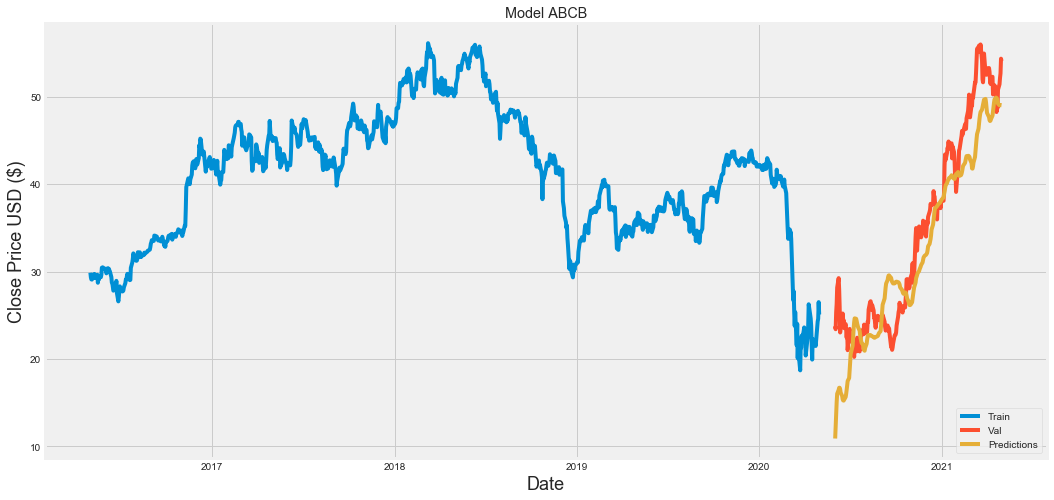

Ticker:  ABCB
LSTM target is:  Close
LSTM features are:  ['Close', '2 YR', 'us_dollar_index', 'personal_sav_rate', 'oil_price', 'schiller_ratio', 'consumer_sentiment', 'public_debt', 'Bullish', 'Bearish', 'gdp', 'cpi', 'unemployment', 'non_farm', 'm2_money', 'st_louis', 'volume']
lookback is:  20
lookahead is:  20
years_window is:  2
length of test window:  270
normalization method:  min_max
 
close_threshold:  0.01
timeframe controlled by master_start and master_end:  True
beginning of timeframe:  2016-05-01
end of timeframe:  2021-05-01
proportion of timeframe for training:  0.8
normalized stats
output table:  C:\personal\karma_stocks_2021\stock_investigation\output\summary20220122-214155.csv
Notebook execution duration:  0:00:42.184348


c:\users\ryanm\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ticker,feature_list,total deviation,avg deviation,max deviation,min deviation,proportion good days
0,ABCB,"['Close', '2 YR', 'us_dollar_index', 'personal...",25.5572,3.8779,0.3682,0.0008,5.2%


In [139]:
# main block to call all the subsidiary functions and loop through the parm CSV, if required
first_multi = True
if multi_parm_run:
    # read the multi_parm CSV file and for each row in it, do an iteration
    multi_file = os.path.join(get_data_path(),multi_parm_file)
    print("multi_file: ",multi_file)
    # df_multi_parm = pd.read_csv(multi_file,encoding = "ISO-8859-1")
    df_multi_parm = pd.read_csv(multi_file)
    print("multi_parm cols are", df_multi_parm.columns)
    # for index, row in df.iterrows():
    #print(row['c1'], row['c2'])
    for index, row in df_multi_parm.iterrows():
        # for each row in the multi_parm CSV file
        for cols in df_multi_parm.columns:
            # for col in the current row in the multi_parm CSV file, replace the current parm value with the one in the CSV file for that row
            if cols in list_parms:
                # parm is a list, so convert string version into Python list
                parms[cols] = row[cols].strip('][').split(', ')
            else:
                parms[cols] = row[cols]
            print("cols is",cols)
            print("parms[cols]",parms[cols])
        # now with the parms set, run the whole iteration
        start, end = set_start_end()
        df_predict, tech_list = define_main_df(start, end, parms['tech_list'])
        # no-op for this entry if no valid tickers
        if len(tech_list) > 0:
            predictions,data,training_data_len,look_ahead_dict,test_data = model_train(start, end,parms['tech_list'],df_predict,parms['look_ahead'],parms['look_back'],parms['training_proportion'])
            summary_df = plot_data(start, end,parms['master_date_mode'],row,parms['tech_list'], predictions,data,training_data_len,look_ahead_dict,parms['look_back'],test_data,parms['training_proportion']) 
            if first_multi:
                first_multi = False
                output_df = summary_df
            else:
                output_df = pd.concat([output_df, summary_df])        
    str_date = datetime.now().strftime("%Y%m%d-%H%M%S")
    file_name = os.path.join(get_path(),"summary"+str_date+".csv")
    print("output table: ",file_name)
    try:
        output_df.to_csv(file_name,index=False)
    except Exception as f:
        if debug_on:
            raise
            print("exception generated "+str(f)+" attempting to write output CSV "+file_name)
        else:
            print("exception not generated")
else:
    # just do one iteration using the parms from the config file
    row = []
    start, end = set_start_end()
    df_predict, tech_list = define_main_df(start, end, parms['tech_list'])
    # no-op if no valid tickers
    if len(tech_list) > 0:
        predictions,data,training_data_len,look_ahead_dict,test_data = model_train(start, end,parms['tech_list'],df_predict,parms['look_ahead'],parms['look_back'],parms['training_proportion'])
        summary_df = plot_data(start, end,parms['master_date_mode'],row,parms['tech_list'], predictions,data,training_data_len,look_ahead_dict,parms['look_back'],test_data,parms['training_proportion'])
        str_date = datetime.now().strftime("%Y%m%d-%H%M%S")
        file_name = os.path.join(get_path(),"summary"+str_date+".csv")
        print("output table: ",file_name)
        summary_df.to_csv(file_name,index=False)
#
# total deviation = sum of difference between actual price and prediction, normalized by average cost
# avg deviation = average difference between actual price and prediction
# max deviation = highest difference between actual price and prediction, normalized by average cost
# proportion good days = proportion of days where difference between actual price and prediction (normalized by avg cost)
# was less than close_threshold value in config file
print("Notebook execution duration: ",str(datetime.now() - start_timestamp))
summary_df.head()


In [140]:
df_predict['ABCB'].tail()

,open,high,low,Close,volume,adj_high,adj_low,adj_close,adj_open,adj_volume,...,consumer_sentiment,public_debt,Bullish,Bearish,gdp,cpi,unemployment,non_farm,m2_money,st_louis
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-26,51.87,52.83,51.2098,51.42,276948.0,NaN,NaN,51.42,NaN,NaN,...,84.9,125.45397,0.526814,0.205047,22722.581,272.265,6.0,144326.0,1.119,-0.07
2021-04-27,51.36,52.19,51.1250,52.15,309910.0,NaN,NaN,52.15,NaN,NaN,...,84.9,125.45397,0.526814,0.205047,22722.581,272.265,6.0,144326.0,1.119,-0.07
2021-04-28,52.35,52.90,51.9800,52.67,343668.0,NaN,NaN,52.67,NaN,NaN,...,84.9,125.45397,0.526814,0.205047,22722.581,272.265,6.0,144326.0,1.119,-0.07
2021-04-29,53.45,54.45,53.0000,54.35,506649.0,NaN,NaN,54.35,NaN,NaN,...,84.9,125.45397,0.526814,0.205047,22722.581,272.265,6.0,144326.0,1.119,-0.07
2021-04-30,53.85,55.02,53.4600,54.09,625000.0,NaN,NaN,54.09,NaN,NaN,...,88.3,125.45397,0.526814,0.205047,22722.581,272.265,6.0,144326.0,1.119,-0.07
